<h1> Bias Improvement in Biased Monte Carlo </h1>

<p> Ideally our bias would be the inverse of the Boltzmann factor of each state, so that all states are visited equally. In the biased system, the transition state isn't really a transition state at all -- it's the same Boltzmann factor as everything else, and doesn't prevent transitions. To do this, I have made a decent guess of the biases and run the simulation. Now based on those simulations I will make updated estimates of the free energy of each of the states, and then created improved weights. </p> 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Read in the energy data, which contains state occupancy and bias </h2>

<p> We read in the energy.dat file as a fwf. Columns 5 and 6 represent the number of bonds, and the mindist bin respectively (remember, we binned the minimum distance, so we could bias with a square well). I'm going to combine the mindist and number of bonds values to create a reaction coordinate, which goes from -3 (when comp. nucleotides are furthest to 4), when everything is bonded.</p> 

In [5]:
data_set = []

for i in range(1,5):
    data = np.array(pd.read_fwf(f'../RUN_{i}/energy.dat',header = None)[[5,6,7]])[1000:]
    keys = -data[:,1]+data[:,0]
    weights = data[:,2]
    data_set.append([keys,weights])

<p> Let's have a look at the trajectories. Note that I've equilibrated by removing the first 1000 steps, so it looks like we don't start from the same place. </p>

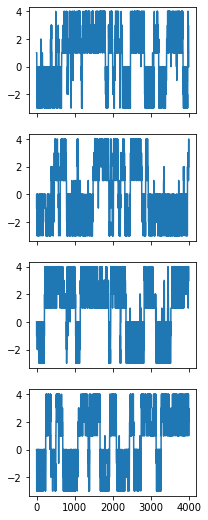

In [7]:
f,ax = plt.subplots(4,1,figsize = (3,9),sharex = True)
for i in range(4):
    ax[i].plot(data_set[i][0])

<p> MUCH BETTER! We're doing regular transitions between the states. </p>

<h2> Let's see which states were visited </h2>

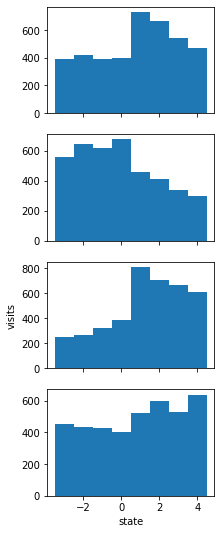

In [9]:
f,ax = plt.subplots(4,1,figsize = (3,9),sharex = True)
for i in range(4):
    ax[i].hist(data_set[i][0],bins = [-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5])
_=ax[-1].set_xlabel('state')
_=ax[2].set_ylabel('visits')

<p> Now, with our updated biases we're visited each state about the same -- flat histogram sampling </p>

<h2> Let's unbias to estimate free energy </h2>

<p> Remember, we biased with a Boltzmann factor of W, so we need to divide by that value to get the true state occupancy </p>

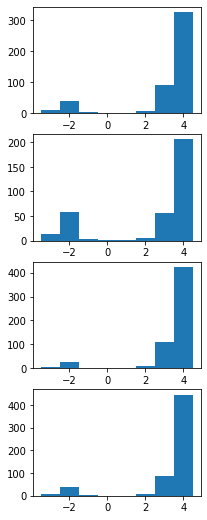

In [11]:
probs = []

f,ax = plt.subplots(4,1,figsize = (3,9))
for i in range(4):
    probs.append(ax[i].hist(data_set[i][0],bins = [-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],weights = 1/data_set[i][1])[0])

<p> We're also now getting much more consistent estimates of free energy between simulations -- there's is an obvious consequence of more efficient sampling -- that there is less variation between different runs. </p>

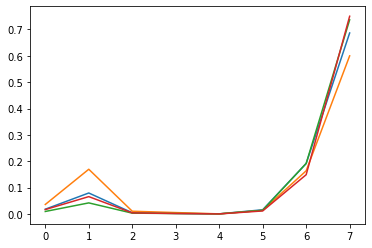

In [14]:
normed = []

for i in probs:
    plt.plot(i/sum(i))
    normed.append(i/sum(i))

<p> Now we can plot a best estimate at occupation </p>

In [15]:
occupation = np.mean(normed,axis = 0)

<p> Now let's plot the free energy as a function of reaction coordinate </p>

Text(0, 0.5, 'free energy (k_BT)')

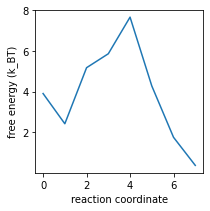

In [21]:
f,ax = plt.subplots(1,1,figsize = (3,3))
plt.plot(-np.log(occupation))
ax.set_xlabel('reaction coordinate')
ax.set_ylabel('free energy (k_BT)')

<p> Of course, we were a bit artificial with our minimum distance biasing -- we should really combine the occupation of all of the unbound states into one if we want a reasonable physical intuition </p>

In [31]:
new_occupation = [sum(occupation[:4])] + list(occupation[4:])

Text(0, 0.5, 'free energy (k_BT)')

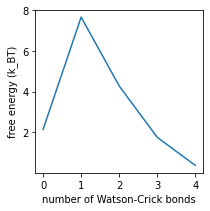

In [35]:
f,ax = plt.subplots(1,1,figsize = (3,3))
plt.plot(-np.log(new_occupation))
ax.set_xlabel('number of Watson-Crick bonds')
ax.set_ylabel('free energy (k_BT)')

<p> We probably also want some error bars on this... the best way is looking between replicas.</p>

In [40]:
def get_free_energy(occupation):
    new_occupation = np.array([sum(occupation[:4])] + list(occupation[4:]))
    fe = -np.log(new_occupation)
    #let's set the unbound state as the zero free energy reference point
    fe = fe - fe[0]
    return fe

In [41]:
fe_estimates = [get_free_energy(occ) for occ in normed]

Text(0, 0.5, 'free energy (k_BT)')

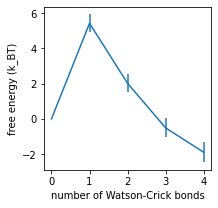

In [46]:
f,ax = plt.subplots(1,1,figsize = (3,3))
plt.errorbar(np.arange(5),np.mean(fe_estimates,axis = 0), np.std(fe_estimates,axis = 0))
ax.set_xlabel('number of Watson-Crick bonds')
ax.set_ylabel('free energy (k_BT)')